## Project 1 - Finding Lane Lines

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


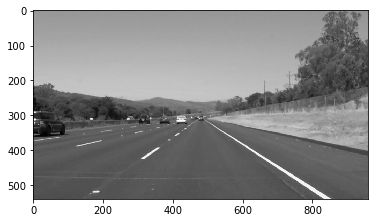

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap = 'gray') 

In [16]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def filter_image(img):
    ''' Function to filter only white and yellow pixels from the image'''
    
    hls_image = cv2.cvtColor(img,cv2.COLOR_BGR2HLS);
    #White filter
    white_lower = np.uint8([0,200,0]);
    white_upper = np.uint8([255,255,255]);
    white_mask = cv2.inRange(img,white_lower,white_upper);
    
    #Yellow filter
    yellow_lower = np.uint8([10,0,100]);
    yellow_upper = np.uint8([40,255,255]);
    yellow_mask = cv2.inRange(img,yellow_lower,yellow_upper);
    
    # combine the masks
    msk = cv2.bitwise_or(white_mask,yellow_mask);
    final_img = cv2.bitwise_and(img,img,mask = msk)
    return final_img


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_points =[];
    left_points = [];
    left_slopes = [];
    right_slopes = [];
    color2 = [0, 255, 0];
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2-x1 ==0:
                continue
            m= (y2-y1)/(x2-x1);
            if m >0 :
                right_points.append([x1,y1]);
                right_points.append([x2,y2]);
                right_slopes.append(m);
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                #print('left lane : ',x1,y1,x2,y2)
            else:
                left_points.append([x1,y1]);
                left_points.append([x2,y2]);
                left_slopes.append(m);
                #cv2.line(img, (x1, y1), (x2, y2), color2, thickness)
                #print('right lane : ',x1,y1,x2,y2)
    
    rp = np.array(right_points);
    rx = rp[:,0]; ry = rp[:,1]; A = np.vstack([rx,np.ones(len(rx))]).T;
    rm,rc = np.linalg.lstsq(A,ry)[0];
    #print('right slope ', rm,'right c',rc);
    rystart = img.shape[0];
    ryend = 320;
    rxstart = int((rystart -rc)/rm);
    rxend = int((ryend -rc)/rm);
    cv2.line(img, (rxstart, rystart), (rxend, ryend), color, thickness)
    
    lp = np.array(left_points);
    lx = lp[:,0]; ly = lp[:,1]; A = np.vstack([lx,np.ones(len(lx))]).T;
    lm,lc = np.linalg.lstsq(A,ly)[0];
    lystart = img.shape[0];
    lyend = 320;
    lxstart = int((lystart -lc)/lm);
    lxend = int((lyend -lc)/lm);
    cv2.line(img, (lxstart, lystart), (lxend, lyend), color2, thickness)
    #print('left slope ', lm,'left c',lc);
    #print('\n left points - ',left_points);
    #print('\n right points - ',right_points);
            
    #print('left points - ', left_points, left_slopes);
    #print('right points - ', right_points, right_slopes);

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def PipeLine(img):
    """
    'img' is the initial image input. This function carries out the entire pipeline of 
    processing functions to identify the lane lines and returns the weighted image with
    the lane lines superimposed on the initial image.
    """
    
    # RGB to Grayscale
    img = filter_image(img);
    gray = grayscale(img);
    
    # Gaussian Smooting
    kernel_size = 15;
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
    
    # Canny edge Parameters
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray,low_threshold,high_threshold)
    
    # Region of interest
    vertices = np.array([[(75,550),(430,340),(550,340),(950,550)]], dtype = np.int32)
    masked_edges = region_of_interest(edges,vertices);
    #plt.imshow(masked_edges)
    '''# masked edges image
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    # Polygon mask
    imshape = image.shape
    vertices = np.array([[(75,550),(430,340),(550,340),(950,550)]], dtype = np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges,mask)
    region_of_interest()'''
    # Hough Transform
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 20
    max_line_gap = 30
    line_image = np.copy(masked_edges)*0
    lines_img = hough_lines(masked_edges,rho,theta,threshold, min_line_length, max_line_gap)

    
    # Weighted Image
    return_img = weighted_img(lines_img,img);    
    return return_img

## Test Images

In [17]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [18]:
'''image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg');
mImg = filter_image(image);
plt.imshow(mImg);
gray = grayscale(mImg);
plt.imshow(gray,cmap = 'gray')
wImg = PipeLine(image)
plt.imshow(wImg)'''

"image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg');\nmImg = filter_image(image);\nplt.imshow(mImg);\ngray = grayscale(mImg);\nplt.imshow(gray,cmap = 'gray')\nwImg = PipeLine(image)\nplt.imshow(wImg)"

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import *
from IPython.display import HTML

In [26]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
     # RGB to Grayscale
    init_img = img;
    img = filter_image(img);
    gray = grayscale(img);
    
    # Gaussian Smooting
    kernel_size = 15;
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
    
    # Canny edge Parameters
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray,low_threshold,high_threshold)
    
    # Region of interest
    vertices = np.array([[(75,550),(430,340),(550,340),(950,550)]], dtype = np.int32)
    masked_edges = region_of_interest(edges,vertices);
    #plt.imshow(masked_edges)
    '''# masked edges image
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    # Polygon mask
    imshape = image.shape
    vertices = np.array([[(75,550),(430,340),(550,340),(950,550)]], dtype = np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges,mask)
    region_of_interest()'''
    # Hough Transform
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 20
    max_line_gap = 30
    lines_img = hough_lines(masked_edges,rho,theta,threshold, min_line_length, max_line_gap)

    
    # Weighted Image
    return_img = weighted_img(lines_img,init_img);    
    return return_img

In [30]:
white_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/challenge.mp4").subclip(0,5)
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")


In [31]:
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.ipython_display(width = 280)


 62%|██████████████████████████████████████████████████▏                              | 78/126 [00:02<00:01, 37.45it/s]

IndexError: too many indices for array

 62%|██████████████████████████████████████████████████▏                              | 78/126 [00:20<00:12,  3.90it/s]

In [29]:
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [00:02<00:00, 60.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 2.4 s


In [18]:
clip1.ipython_display(width = 280)

OSError: [WinError 6] The handle is invalid